# PCL Detection — Binary Classification Pipeline

Systematic approach to PCL binary classification:
1. True baseline (RoBERTa-base, unweighted CE, t=0.5)
2. Incremental improvements: weighted CE, threshold optimisation, multi-task learning
3. Ablation studies showing contribution of each component
4. Error analysis and custom metrics

## 1. Imports & Setup

In [1]:
import os
import ast
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f'Device: {DEVICE}')

# Auto-detect environment and set batch sizes accordingly
ON_GPUDOJO = 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ or DEVICE.type == 'cuda'

if ON_GPUDOJO:
    BASE_DIR = '/vol/bitbucket/akc123/PCL_Detection'
    BATCH_SIZE = 4
    GRAD_ACCUM = 8
    EVAL_BATCH_SIZE = 16
    print('Running on GPU — batch_size=4, grad_accum=8')
else:
    BASE_DIR = '/Users/alexanderchow/Documents/Y3/60035_NLP/PCL_Detection'
    BATCH_SIZE = 2
    GRAD_ACCUM = 16
    EVAL_BATCH_SIZE = 4
    print('Running locally (MPS/CPU) — batch_size=2, grad_accum=16')

print(f'Effective batch size: {BATCH_SIZE * GRAD_ACCUM}')

DATA_DIR = f'{BASE_DIR}/data'
SPLITS_DIR = f'{BASE_DIR}/practice splits'
CHECKPOINT_DIR = f'{BASE_DIR}/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

/vol/bitbucket/akc123/PCL_Detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


Device: cuda
Running on GPU — batch_size=4, grad_accum=8
Effective batch size: 32


## 2. Data Loading & Preprocessing

In [2]:
# Load main PCL dataset (skip 4 header lines)
pcl_df = pd.read_csv(
    f'{DATA_DIR}/dontpatronizeme_pcl.tsv',
    sep='\t', skiprows=4, header=None,
    names=['par_id', 'art_id', 'keyword', 'country_code', 'text', 'label'],
    quoting=3
)
pcl_df['par_id'] = pcl_df['par_id'].astype(int)
pcl_df['label'] = pcl_df['label'].astype(int)

# Binary label: {0,1}->0, {2,3,4}->1
pcl_df['binary_label'] = (pcl_df['label'] >= 2).astype(int)

# Clean text: strip <h> tags and HTML artifacts
def clean_text(text):
    text = str(text)
    text = re.sub(r'<[^>]+>', ' ', text)       # remove HTML tags
    text = re.sub(r'&[a-z]+;', ' ', text)      # remove HTML entities
    text = re.sub(r'\s+', ' ', text).strip()    # normalise whitespace
    return text
pcl_df['text'] = pcl_df['text'].apply(clean_text)

# Load train/dev splits
train_splits = pd.read_csv(f'{SPLITS_DIR}/train_semeval_parids-labels.csv')
dev_splits = pd.read_csv(f'{SPLITS_DIR}/dev_semeval_parids-labels.csv')
train_splits['par_id'] = train_splits['par_id'].astype(int)
dev_splits['par_id'] = dev_splits['par_id'].astype(int)

# Parse category labels from split files (7-dim multi-label vectors)
def parse_category_label(label_str):
    try:
        return ast.literal_eval(label_str)
    except:
        return [0, 0, 0, 0, 0, 0, 0]

train_splits['category_labels'] = train_splits['label'].apply(parse_category_label)
dev_splits['category_labels'] = dev_splits['label'].apply(parse_category_label)

# Merge with main data
train_ids = set(train_splits['par_id'].values)
dev_ids = set(dev_splits['par_id'].values)

train_df = pcl_df[pcl_df['par_id'].isin(train_ids)].copy()
dev_df = pcl_df[pcl_df['par_id'].isin(dev_ids)].copy()

# Merge category labels
cat_train = train_splits[['par_id', 'category_labels']].copy()
cat_dev = dev_splits[['par_id', 'category_labels']].copy()

train_df = train_df.merge(cat_train, on='par_id', how='left')
dev_df = dev_df.merge(cat_dev, on='par_id', how='left')

# Fill missing category labels with zeros
train_df['category_labels'] = train_df['category_labels'].apply(
    lambda x: x if isinstance(x, list) else [0]*7
)
dev_df['category_labels'] = dev_df['category_labels'].apply(
    lambda x: x if isinstance(x, list) else [0]*7
)

print(f'Train: {len(train_df)} samples ({train_df["binary_label"].sum()} PCL)')
print(f'Dev:   {len(dev_df)} samples ({dev_df["binary_label"].sum()} PCL)')
print(f'\nTrain class distribution:')
print(train_df['binary_label'].value_counts().sort_index())

Train: 8375 samples (794 PCL)
Dev:   2094 samples (199 PCL)

Train class distribution:
binary_label
0    7581
1     794
Name: count, dtype: int64


## 3. Dataset & DataLoader

In [3]:
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class PCLDataset(Dataset):
    def __init__(self, texts, binary_labels, category_labels, tokenizer, max_length):
        self.texts = texts
        self.binary_labels = binary_labels
        self.category_labels = category_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'binary_label': torch.tensor(self.binary_labels[idx], dtype=torch.long),
            'category_labels': torch.tensor(self.category_labels[idx], dtype=torch.float),
        }

def create_datasets(train_df, dev_df, tokenizer, max_length):
    train_dataset = PCLDataset(
        texts=train_df['text'].tolist(),
        binary_labels=train_df['binary_label'].tolist(),
        category_labels=train_df['category_labels'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )
    dev_dataset = PCLDataset(
        texts=dev_df['text'].tolist(),
        binary_labels=dev_df['binary_label'].tolist(),
        category_labels=dev_df['category_labels'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )
    return train_dataset, dev_dataset

print(f'Tokenizer loaded: {MODEL_NAME}')
print(f'Max length: {MAX_LENGTH}')

Tokenizer loaded: roberta-base
Max length: 256


## 4. Model Architecture

In [4]:
class PCLMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_categories=7, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.binary_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)
        )

        self.category_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_categories)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        binary_logits = self.binary_head(cls_output)
        category_logits = self.category_head(cls_output)

        return binary_logits, category_logits


class BaselineModel(nn.Module):
    """Simple RoBERTa-base binary classifier (baseline)."""
    def __init__(self, model_name='roberta-base', dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits, None  # None for compatibility with evaluate()

print('Model classes defined: PCLMultiTaskModel, BaselineModel')

Model classes defined: PCLMultiTaskModel, BaselineModel


## 5. Training Loop

In [5]:
import gc
print_every_updates = 20

def free_gpu():
    """Clear GPU memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def evaluate(model, dataloader, device, threshold=0.5):
    """Evaluate model on a dataset, return metrics and probabilities."""
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['binary_label']

            binary_logits, _ = model(input_ids, attention_mask)
            probs = F.softmax(binary_logits, dim=1)[:, 1].cpu()

            all_probs.extend(probs.tolist())
            all_labels.extend(labels.tolist())

    all_preds = [1 if p >= threshold else 0 for p in all_probs]
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    precision = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)

    return {
        'f1': f1, 'precision': precision, 'recall': recall,
        'preds': all_preds, 'labels': all_labels, 'probs': all_probs,
        'threshold': threshold
    }


def find_best_threshold(probs, labels):
    """Sweep thresholds on probability outputs to maximise F1."""
    best_f1 = 0.0
    best_threshold = 0.5
    for t in np.arange(0.05, 0.95, 0.01):
        preds = [1 if p >= t else 0 for p in probs]
        f1 = f1_score(labels, preds, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold, best_f1


def train_model(config_name, train_df, dev_df, tokenizer,
                use_weighted_ce=True, use_threshold_opt=True, use_multitask=False,
                num_epochs=10, batch_size=BATCH_SIZE, grad_accum_steps=GRAD_ACCUM,
                lr=2e-5, weight_decay=0.01, patience=3, category_weight=0.3,
                model_class=PCLMultiTaskModel, model_name='roberta-base'):
    """Train a model with the given configuration."""
    free_gpu()

    print(f'\n{"="*60}')
    print(f'Training Config: {config_name}')
    print(f'  Model: {model_name}')
    print(f'  Weighted CE: {use_weighted_ce} | Multi-task: {use_multitask}')
    print(f'  Threshold Opt: {use_threshold_opt}')
    print(f'  Epochs: {num_epochs} | LR: {lr} | Patience: {patience}')
    print(f'  Batch: {batch_size} x {grad_accum_steps} = {batch_size * grad_accum_steps} effective')
    print(f'{"="*60}')

    effective_train_df = train_df.copy()

    # Create tokenizer for this model
    tok = AutoTokenizer.from_pretrained(model_name)

    train_dataset = PCLDataset(
        texts=effective_train_df['text'].tolist(),
        binary_labels=effective_train_df['binary_label'].tolist(),
        category_labels=effective_train_df['category_labels'].tolist(),
        tokenizer=tok, max_length=MAX_LENGTH
    )
    dev_dataset = PCLDataset(
        texts=dev_df['text'].tolist(),
        binary_labels=dev_df['binary_label'].tolist(),
        category_labels=dev_df['category_labels'].tolist(),
        tokenizer=tok, max_length=MAX_LENGTH
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    dev_loader = DataLoader(dev_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)

    # Model
    if model_class == BaselineModel:
        model = BaselineModel(model_name=model_name).to(DEVICE).float()
    else:
        model = PCLMultiTaskModel(model_name=model_name).to(DEVICE).float()

    # Loss function
    if use_weighted_ce:
        n_neg = (effective_train_df['binary_label'] == 0).sum()
        n_pos = (effective_train_df['binary_label'] == 1).sum()
        weight = torch.tensor([1.0, n_neg / n_pos], dtype=torch.float).to(DEVICE)
        binary_criterion = nn.CrossEntropyLoss(weight=weight)
        print(f'  CE class weights: [{weight[0]:.3f}, {weight[1]:.3f}]')
    else:
        binary_criterion = nn.CrossEntropyLoss()
        print(f'  Unweighted CE')

    category_criterion = nn.BCEWithLogitsLoss()

    # Optimizer & scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_epochs // grad_accum_steps
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0.0
    patience_counter = 0
    history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        optimizer.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            binary_labels = batch['binary_label'].to(DEVICE)
            category_labels = batch['category_labels'].to(DEVICE)

            binary_logits, category_logits = model(input_ids, attention_mask)

            loss_binary = binary_criterion(binary_logits, binary_labels)
            if use_multitask and category_logits is not None:
                loss_category = category_criterion(category_logits, category_labels)
                loss = loss_binary + category_weight * loss_category
            else:
                loss = loss_binary
            loss = loss / grad_accum_steps

            loss.backward()
            total_loss += loss.item() * grad_accum_steps

            if (step + 1) % grad_accum_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                update = (step + 1) // grad_accum_steps
                if update % print_every_updates == 0:
                    avg_recent = total_loss / (step + 1)
                    print(f"    step {step+1}/{len(train_loader)} "
                          f"(update {update}) | avg loss so far: {avg_recent:.4f}")

        # Handle remaining gradients
        if (step + 1) % grad_accum_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_loader)

        # Evaluate on dev at t=0.5
        metrics = evaluate(model, dev_loader, DEVICE, threshold=0.5)
        history.append({
            'epoch': epoch + 1, 'loss': avg_loss,
            'f1': metrics['f1'], 'precision': metrics['precision'], 'recall': metrics['recall']
        })

        print(f'  Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f} | '
              f'F1: {metrics["f1"]:.4f} | P: {metrics["precision"]:.4f} | R: {metrics["recall"]:.4f}')

        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            patience_counter = 0
            torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/{config_name}_best.pt')
            print(f'  -> New best F1! Saved.')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'  Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/{config_name}_best.pt', weights_only=True))

    # Evaluate at t=0.5
    final_metrics = evaluate(model, dev_loader, DEVICE, threshold=0.5)

    # Threshold optimisation (if enabled)
    if use_threshold_opt:
        best_thresh, _ = find_best_threshold(final_metrics['probs'], final_metrics['labels'])
        thresh_metrics = evaluate(model, dev_loader, DEVICE, threshold=best_thresh)
    else:
        best_thresh = 0.5
        thresh_metrics = final_metrics

    print(f'\n  Dev F1 @ t=0.50: {final_metrics["f1"]:.4f}')
    if use_threshold_opt:
        print(f'  Dev F1 @ t={best_thresh:.2f} (optimised): {thresh_metrics["f1"]:.4f}')
    print(classification_report(
        thresh_metrics['labels'], thresh_metrics['preds'],
        target_names=['No PCL', 'PCL'], digits=4
    ))

    # Move to CPU and free GPU
    model = model.cpu()
    del model; free_gpu()

    return final_metrics, thresh_metrics, history, best_thresh, tok

print('Training function defined.')

Training function defined.


## 6. True Baseline: RoBERTa-base + Unweighted CE + t=0.5

In [18]:
# True baseline: RoBERTa-base, unweighted CE, no tricks, fixed threshold=0.5
BASELINE_MODEL = 'roberta-base'

metrics_bl, thresh_metrics_bl, history_bl, thresh_bl, tok_bl = train_model(
    config_name='baseline',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=BaselineModel, model_name=BASELINE_MODEL,
    use_weighted_ce=False, use_multitask=False, use_threshold_opt=False,
    num_epochs=20, lr=2e-5, patience=5
)


Training Config: baseline
  Model: roberta-base
  Weighted CE: False | Multi-task: False
  Threshold Opt: False
  Epochs: 20 | LR: 2e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1495.35it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Unweighted CE
    step 160/2094 (update 20) | avg loss so far: 0.6716
    step 320/2094 (update 40) | avg loss so far: 0.6459
    step 480/2094 (update 60) | avg loss so far: 0.5967
    step 640/2094 (update 80) | avg loss so far: 0.5369
    step 800/2094 (update 100) | avg loss so far: 0.4966
    step 960/2094 (update 120) | avg loss so far: 0.4734
    step 1120/2094 (update 140) | avg loss so far: 0.4523
    step 1280/2094 (update 160) | avg loss so far: 0.4350
    step 1440/2094 (update 180) | avg loss so far: 0.4170
    step 1600/2094 (update 200) | avg loss so far: 0.4009
    step 1760/2094 (update 220) | avg loss so far: 0.3882
    step 1920/2094 (update 240) | avg loss so far: 0.3754
    step 2080/2094 (update 260) | avg loss so far: 0.3642
  Epoch 1/20 — Loss: 0.3626 | F1: 0.4068 | P: 0.6250 | R: 0.3015
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.2469
    step 320/2094 (update 40) | avg loss so far: 0.2354
    step 480/2094 (update 60) | avg lo

## 7. Incremental Improvements

In [27]:
# Config A: Weighted CE + Threshold Optimisation + Multi-task Learning
metrics_a, thresh_metrics_a, history_a, thresh_a, tok_a = train_model(
    config_name='config_A_weighted_ce_thresh_mt',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=PCLMultiTaskModel, model_name='roberta-base',
    use_weighted_ce=True, use_multitask=True, use_threshold_opt=True,
    num_epochs=20, lr=2e-5, patience=5
)


Training Config: config_A_weighted_ce_thresh_mt
  Model: roberta-base
  Weighted CE: True | Multi-task: True
  Threshold Opt: True
  Epochs: 20 | LR: 2e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1468.59it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  CE class weights: [1.000, 9.548]
    step 160/2094 (update 20) | avg loss so far: 0.8655
    step 320/2094 (update 40) | avg loss so far: 0.8539
    step 480/2094 (update 60) | avg loss so far: 0.8352
    step 640/2094 (update 80) | avg loss so far: 0.8156
    step 800/2094 (update 100) | avg loss so far: 0.8047
    step 960/2094 (update 120) | avg loss so far: 0.7962
    step 1120/2094 (update 140) | avg loss so far: 0.7718
    step 1280/2094 (update 160) | avg loss so far: 0.7569
    step 1440/2094 (update 180) | avg loss so far: 0.7279
    step 1600/2094 (update 200) | avg loss so far: 0.7014
    step 1760/2094 (update 220) | avg loss so far: 0.6753
    step 1920/2094 (update 240) | avg loss so far: 0.6679
    step 2080/2094 (update 260) | avg loss so far: 0.6489
  Epoch 1/20 — Loss: 0.6468 | F1: 0.4877 | P: 0.3519 | R: 0.7940
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.3913
    step 320/2094 (update 40) | avg loss so far: 0.4242
    step 480/2094 (

In [ ]:
# Config B: Weighted CE + Threshold Optimisation + Multi-task Learning
metrics_b, thresh_metrics_b, history_b, thresh_b, tok_b = train_model(
    config_name='config_B_weighted_ce_thresh_mt_large',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=PCLMultiTaskModel, model_name='roberta-large',
    use_weighted_ce=True, use_multitask=True, use_threshold_opt=True,
    num_epochs=20, lr=1e-5, patience=5
)


Training Config: config_B_weighted_ce_thresh_mt
  Model: roberta-large
  Weighted CE: True | Multi-task: True
  Threshold Opt: True
  Epochs: 20 | LR: 1e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 389/389 [00:01<00:00, 333.06it/s, Materializing param=encoder.layer.23.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  CE class weights: [1.000, 9.548]
    step 160/2094 (update 20) | avg loss so far: 1.2774
    step 320/2094 (update 40) | avg loss so far: 1.2746
    step 480/2094 (update 60) | avg loss so far: 1.2198
    step 640/2094 (update 80) | avg loss so far: 1.1430
    step 800/2094 (update 100) | avg loss so far: 1.1351
    step 960/2094 (update 120) | avg loss so far: 1.0829
    step 1120/2094 (update 140) | avg loss so far: 1.0470
    step 1280/2094 (update 160) | avg loss so far: 1.0098
    step 1440/2094 (update 180) | avg loss so far: 0.9827
    step 1600/2094 (update 200) | avg loss so far: 0.9597
    step 1760/2094 (update 220) | avg loss so far: 0.9337
    step 1920/2094 (update 240) | avg loss so far: 0.9066
    step 2080/2094 (update 260) | avg loss so far: 0.8817
  Epoch 1/20 — Loss: 0.8800 | F1: 0.4033 | P: 0.2781 | R: 0.7337
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.5479
    step 320/2094 (update 40) | avg loss so far: 0.5447
    step 480/2094 (

## 8. Ablation Studies

In [7]:
# Ablation 1: Config A without multi-task (isolate multi-task contribution)
metrics_abl_nomt, thresh_metrics_abl_nomt, history_abl_nomt, thresh_abl_nomt, tok_abl_nomt = train_model(
    config_name='ablation_no_multitask',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=BaselineModel, model_name='roberta-base',
    use_weighted_ce=True, use_multitask=False, use_threshold_opt=True,
    lr=2e-5, patience=5
)


Training Config: ablation_no_multitask
  Model: roberta-base
  Weighted CE: True | Multi-task: False
  Threshold Opt: True
  Epochs: 10 | LR: 2e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 404.35it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  CE class weights: [1.000, 9.548]
    step 160/2094 (update 20) | avg loss so far: 0.7491
    step 320/2094 (update 40) | avg loss so far: 0.7253
    step 480/2094 (update 60) | avg loss so far: 0.6910
    step 640/2094 (update 80) | avg loss so far: 0.6616
    step 800/2094 (update 100) | avg loss so far: 0.6406
    step 960/2094 (update 120) | avg loss so far: 0.6140
    step 1120/2094 (update 140) | avg loss so far: 0.5951
    step 1280/2094 (update 160) | avg loss so far: 0.5708
    step 1440/2094 (update 180) | avg loss so far: 0.5560
    step 1600/2094 (update 200) | avg loss so far: 0.5431
    step 1760/2094 (update 220) | avg loss so far: 0.5323
    step 1920/2094 (update 240) | avg loss so far: 0.5175
    step 2080/2094 (update 260) | avg loss so far: 0.5115
  Epoch 1/10 — Loss: 0.5129 | F1: 0.4059 | P: 0.7639 | R: 0.2764
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.3215
    step 320/2094 (update 40) | avg loss so far: 0.3140
    step 480/2094 (

In [8]:
# Ablation 2: Config A without threshold opt (isolate threshold contribution)
metrics_abl_nothresh, thresh_metrics_abl_nothresh, history_abl_nothresh, thresh_abl_nothresh, tok_abl_nothresh = train_model(
    config_name='ablation_no_thresh',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=PCLMultiTaskModel, model_name='roberta-base',
    use_weighted_ce=True, use_multitask=True, use_threshold_opt=False,
    lr=2e-5, patience=5
)


Training Config: ablation_no_thresh
  Model: roberta-base
  Weighted CE: True | Multi-task: True
  Threshold Opt: False
  Epochs: 10 | LR: 2e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1562.07it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  CE class weights: [1.000, 9.548]
    step 160/2094 (update 20) | avg loss so far: 0.9684
    step 320/2094 (update 40) | avg loss so far: 0.9358
    step 480/2094 (update 60) | avg loss so far: 0.8940
    step 640/2094 (update 80) | avg loss so far: 0.8625
    step 800/2094 (update 100) | avg loss so far: 0.8471
    step 960/2094 (update 120) | avg loss so far: 0.8118
    step 1120/2094 (update 140) | avg loss so far: 0.7679
    step 1280/2094 (update 160) | avg loss so far: 0.7338
    step 1440/2094 (update 180) | avg loss so far: 0.7013
    step 1600/2094 (update 200) | avg loss so far: 0.6762
    step 1760/2094 (update 220) | avg loss so far: 0.6599
    step 1920/2094 (update 240) | avg loss so far: 0.6468
    step 2080/2094 (update 260) | avg loss so far: 0.6261
  Epoch 1/10 — Loss: 0.6242 | F1: 0.5333 | P: 0.4555 | R: 0.6432
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.3855
    step 320/2094 (update 40) | avg loss so far: 0.3809
    step 480/2094 (

In [9]:
# Ablation 3: Config A without weighted CE (isolate weighted CE contribution)
metrics_abl_nowe, thresh_metrics_abl_nowe, history_abl_nowe, thresh_abl_nowe, tok_abl_nowe = train_model(
    config_name='ablation_no_weighted_ce',
    train_df=train_df, dev_df=dev_df, tokenizer=tokenizer,
    model_class=PCLMultiTaskModel, model_name='roberta-base',
    use_weighted_ce=False, use_multitask=True, use_threshold_opt=True,
    lr=2e-5, patience=5
)


Training Config: ablation_no_weighted_ce
  Model: roberta-base
  Weighted CE: False | Multi-task: True
  Threshold Opt: True
  Epochs: 10 | LR: 2e-05 | Patience: 5
  Batch: 4 x 8 = 32 effective


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1505.61it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Unweighted CE
    step 160/2094 (update 20) | avg loss so far: 0.7331
    step 320/2094 (update 40) | avg loss so far: 0.7018
    step 480/2094 (update 60) | avg loss so far: 0.6422
    step 640/2094 (update 80) | avg loss so far: 0.6121
    step 800/2094 (update 100) | avg loss so far: 0.5829
    step 960/2094 (update 120) | avg loss so far: 0.5466
    step 1120/2094 (update 140) | avg loss so far: 0.5122
    step 1280/2094 (update 160) | avg loss so far: 0.4821
    step 1440/2094 (update 180) | avg loss so far: 0.4617
    step 1600/2094 (update 200) | avg loss so far: 0.4428
    step 1760/2094 (update 220) | avg loss so far: 0.4331
    step 1920/2094 (update 240) | avg loss so far: 0.4213
    step 2080/2094 (update 260) | avg loss so far: 0.4118
  Epoch 1/10 — Loss: 0.4109 | F1: 0.4836 | P: 0.5956 | R: 0.4070
  -> New best F1! Saved.
    step 160/2094 (update 20) | avg loss so far: 0.2089
    step 320/2094 (update 40) | avg loss so far: 0.2328
    step 480/2094 (update 60) | avg lo

## 9. Results Comparison & Best Model Selection

In [28]:
# ---- Results comparison table ----
results = pd.DataFrame([
    {
        'Config': 'Baseline (unweighted CE, t=0.5)',
        'Threshold': '0.50',
        'F1': thresh_metrics_bl['f1'],
        'Precision': thresh_metrics_bl['precision'],
        'Recall': thresh_metrics_bl['recall'],
    },
    {
        'Config': 'A: + Weighted CE + Thresh Opt + Multi-task',
        'Threshold': f'{thresh_a:.2f}',
        'F1': thresh_metrics_a['f1'],
        'Precision': thresh_metrics_a['precision'],
        'Recall': thresh_metrics_a['recall'],
    },
    {
        'Config': 'B: + Weighted CE + Thresh Opt + Multi-task',
        'Threshold': f'{thresh_b:.2f}',
        'F1': thresh_metrics_b['f1'],
        'Precision': thresh_metrics_b['precision'],
        'Recall': thresh_metrics_b['recall'],
    },
    {
        'Config': 'Ablation: A w/o Multi-task',
        'Threshold': f'{thresh_abl_nomt:.2f}',
        'F1': thresh_metrics_abl_nomt['f1'],
        'Precision': thresh_metrics_abl_nomt['precision'],
        'Recall': thresh_metrics_abl_nomt['recall'],
    },
    {
        'Config': 'Ablation: A w/o Threshold Opt',
        'Threshold': '0.50',
        'F1': thresh_metrics_abl_nothresh['f1'],
        'Precision': thresh_metrics_abl_nothresh['precision'],
        'Recall': thresh_metrics_abl_nothresh['recall'],
    },
    {
        'Config': 'Ablation: A w/o Weighted CE',
        'Threshold': f'{thresh_abl_nowe:.2f}',
        'F1': thresh_metrics_abl_nowe['f1'],
        'Precision': thresh_metrics_abl_nowe['precision'],
        'Recall': thresh_metrics_abl_nowe['recall'],
    },
])

print('\n' + '='*80)
print('RESULTS COMPARISON (all models evaluated on dev set)')
print('='*80)
print(results.to_string(index=False, float_format='{:.4f}'.format))

# Best model is Config A
best_metrics = thresh_metrics_a
best_threshold = thresh_a
best_tok = tok_a
best_ckpt_name = 'config_A_weighted_ce_thresh_mt'
best_model_class = PCLMultiTaskModel
best_model_name = 'roberta-base'
best_key = 'A'

improvement = best_metrics['f1'] - thresh_metrics_bl['f1']
print(f'\n** Best model: Config A (F1={best_metrics["f1"]:.4f} @ t={best_threshold:.2f}) **')
print(f'   Improvement over baseline: +{improvement:.4f} F1')


RESULTS COMPARISON (all models evaluated on dev set)
                                    Config Threshold     F1  Precision  Recall
           Baseline (unweighted CE, t=0.5)      0.50 0.6139     0.5872  0.6432
A: + Weighted CE + Thresh Opt + Multi-task      0.45 0.6373     0.6220  0.6533
B: + Weighted CE + Thresh Opt + Multi-task      0.61 0.6133     0.6534  0.5779
                Ablation: A w/o Multi-task      0.51 0.6005     0.5556  0.6533
             Ablation: A w/o Threshold Opt      0.50 0.6061     0.6091  0.6030
               Ablation: A w/o Weighted CE      0.23 0.6210     0.6048  0.6382

** Best model: Config A (F1=0.6373 @ t=0.45) **
   Improvement over baseline: +0.0233 F1


## 10. Generate dev.txt and test.txt Predictions

In [29]:
# ---- Dev predictions ----
dev_preds = best_metrics['preds']
dev_pred_path = f'{BASE_DIR}/dev.txt'
with open(dev_pred_path, 'w') as f:
    for p in dev_preds:
        f.write(f'{p}\n')
print(f'Dev predictions saved to {dev_pred_path}')
print(f'  {len(dev_preds)} predictions, {sum(dev_preds)} predicted PCL')

# ---- Test predictions ----
test_df = pd.read_csv(f'{DATA_DIR}/task4_test.tsv', sep='\t', header=None,
                       names=['par_id', 'art_id', 'keyword', 'country_code', 'text'])
test_df['text'] = test_df['text'].apply(clean_text)
print(f'\nTest set: {len(test_df)} samples')

test_dataset = PCLDataset(
    texts=test_df['text'].tolist(),
    binary_labels=[0] * len(test_df),
    category_labels=[[0]*7] * len(test_df),
    tokenizer=best_tok, max_length=MAX_LENGTH
)
test_loader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)

# Reload best model from checkpoint
best_model = PCLMultiTaskModel(model_name=best_model_name).to(DEVICE)
best_model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/{best_ckpt_name}_best.pt', weights_only=True, map_location=DEVICE))
best_model.eval()

test_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        binary_logits, _ = best_model(input_ids, attention_mask)
        probs = F.softmax(binary_logits, dim=1)[:, 1].cpu().tolist()
        test_probs.extend(probs)

del best_model; gc.collect(); torch.cuda.empty_cache()

test_preds = [1 if p >= best_threshold else 0 for p in test_probs]

test_pred_path = f'{BASE_DIR}/test.txt'
with open(test_pred_path, 'w') as f:
    for p in test_preds:
        f.write(f'{p}\n')
print(f'Test predictions saved to {test_pred_path}')
print(f'  {len(test_preds)} predictions, {sum(test_preds)} predicted PCL')
print(f'  Using threshold: {best_threshold:.2f}')

Dev predictions saved to /vol/bitbucket/akc123/PCL_Detection/dev.txt
  2094 predictions, 209 predicted PCL

Test set: 3832 samples


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1408.53it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Test predictions saved to /vol/bitbucket/akc123/PCL_Detection/test.txt
  3832 predictions, 336 predicted PCL
  Using threshold: 0.45


## 11. Error Analysis

In [34]:
# ---- Error analysis: compare baseline vs best model ----
from collections import Counter

# Reload baseline from checkpoint
model_baseline = BaselineModel(model_name=BASELINE_MODEL).to(DEVICE)
model_baseline.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/baseline_best.pt', weights_only=True, map_location=DEVICE))

baseline_dev_metrics = evaluate(model_baseline,
    DataLoader(PCLDataset(dev_df['text'].tolist(), dev_df['binary_label'].tolist(),
                          dev_df['category_labels'].tolist(), tok_bl, MAX_LENGTH),
               batch_size=EVAL_BATCH_SIZE, shuffle=False),
    DEVICE, threshold=0.5)

del model_baseline; gc.collect(); torch.cuda.empty_cache()

baseline_preds = baseline_dev_metrics['preds']
baseline_probs = baseline_dev_metrics['probs']
best_preds = best_metrics['preds']
best_probs = best_metrics['probs']
true_labels = best_metrics['labels']
dev_texts = dev_df['text'].tolist()
dev_keywords = dev_df['keyword'].tolist()
dev_categories = dev_df['category_labels'].tolist()

# ============================================================
# 1. Four-quadrant classification: baseline vs best model
# ============================================================
both_correct = []    # a) both correct
both_wrong = []      # b) both wrong
base_right_best_wrong = []  # c) baseline correct, best wrong
base_wrong_best_right = []  # d) baseline wrong, best correct

for i, (true, bp, mp) in enumerate(zip(true_labels, baseline_preds, best_preds)):
    b_correct = (bp == true)
    m_correct = (mp == true)
    if b_correct and m_correct:
        both_correct.append(i)
    elif not b_correct and not m_correct:
        both_wrong.append(i)
    elif b_correct and not m_correct:
        base_right_best_wrong.append(i)
    else:
        base_wrong_best_right.append(i)

print('=' * 70)
print('ERROR ANALYSIS: Baseline vs Best Model on Dev Set')
print('=' * 70)

n = len(true_labels)
print(f'\n1. PREDICTION AGREEMENT QUADRANTS (n={n})')
print(f'   a) Both correct:                    {len(both_correct):>5} ({100*len(both_correct)/n:.1f}%)')
print(f'   b) Both wrong:                      {len(both_wrong):>5} ({100*len(both_wrong)/n:.1f}%)')
print(f'   c) Baseline correct, best wrong:    {len(base_right_best_wrong):>5} ({100*len(base_right_best_wrong)/n:.1f}%)')
print(f'   d) Baseline wrong, best correct:    {len(base_wrong_best_right):>5} ({100*len(base_wrong_best_right)/n:.1f}%)')

# ============================================================
# 2. Breakdown by error type within each quadrant
# ============================================================
def error_type_breakdown(indices, labels, bl_preds, best_preds):
    """Classify errors as FP or FN for each model."""
    stats = {'bl_fp': 0, 'bl_fn': 0, 'best_fp': 0, 'best_fn': 0}
    for i in indices:
        if labels[i] == 0 and bl_preds[i] == 1: stats['bl_fp'] += 1
        if labels[i] == 1 and bl_preds[i] == 0: stats['bl_fn'] += 1
        if labels[i] == 0 and best_preds[i] == 1: stats['best_fp'] += 1
        if labels[i] == 1 and best_preds[i] == 0: stats['best_fn'] += 1
    return stats

print(f'\n2. CONFUSION MATRIX COMPARISON')
print(f'   {"Metric":<25} {"Baseline":>10} {"Best Model":>12}')
print(f'   {"-"*50}')
for label_name, true_val, pred_val in [('True Positives', 1, 1), ('True Negatives', 0, 0),
                                         ('False Positives', 0, 1), ('False Negatives', 1, 0)]:
    bl_count = sum(1 for t, p in zip(true_labels, baseline_preds) if t == true_val and p == pred_val)
    best_count = sum(1 for t, p in zip(true_labels, best_preds) if t == true_val and p == pred_val)
    print(f'   {label_name:<25} {bl_count:>10} {best_count:>12}')

# ============================================================
# 3. Quadrant a) deep dive — both models correct (easy cases)
# ============================================================
print(f'\n{"="*70}')
print(f'3. BOTH MODELS CORRECT — "easy" examples ({len(both_correct)} total)')
print(f'{"="*70}')

both_correct_pcl = [i for i in both_correct if true_labels[i] == 1]
both_correct_nopcl = [i for i in both_correct if true_labels[i] == 0]
print(f'   Both correctly identified as PCL:     {len(both_correct_pcl)}')
print(f'   Both correctly identified as non-PCL: {len(both_correct_nopcl)}')

print(f'\n   --- PCL correctly caught by BOTH models ({min(5, len(both_correct_pcl))}/{len(both_correct_pcl)} shown) ---')
print(f'   (These show what "obvious" PCL looks like to the models)')
for idx in both_correct_pcl[:5]:
    print(f'   [{idx}] (bl_prob={baseline_probs[idx]:.3f}, best_prob={best_probs[idx]:.3f})')
    print(f'         keyword="{dev_keywords[idx]}"')
    print(f'         "{dev_texts[idx][:200]}"')
    print()

# Confidence comparison: are both models equally confident on easy cases?
if both_correct_pcl:
    bl_probs_easy_pcl = [baseline_probs[i] for i in both_correct_pcl]
    best_probs_easy_pcl = [best_probs[i] for i in both_correct_pcl]
    print(f'   Confidence on correctly detected PCL:')
    print(f'     Baseline:   mean={np.mean(bl_probs_easy_pcl):.3f}  median={np.median(bl_probs_easy_pcl):.3f}')
    print(f'     Best model: mean={np.mean(best_probs_easy_pcl):.3f}  median={np.median(best_probs_easy_pcl):.3f}')

if both_correct_nopcl:
    bl_probs_easy_nopcl = [baseline_probs[i] for i in both_correct_nopcl]
    best_probs_easy_nopcl = [best_probs[i] for i in both_correct_nopcl]
    print(f'   Confidence on correctly rejected non-PCL:')
    print(f'     Baseline:   mean={np.mean(bl_probs_easy_nopcl):.3f}  median={np.median(bl_probs_easy_nopcl):.3f}')
    print(f'     Best model: mean={np.mean(best_probs_easy_nopcl):.3f}  median={np.median(best_probs_easy_nopcl):.3f}')

# ============================================================
# 4. Quadrant b) deep dive — both models wrong (hardest cases)
# ============================================================
print(f'\n{"="*70}')
print(f'4. BOTH MODELS WRONG — hardest examples ({len(both_wrong)} total)')
print(f'{"="*70}')

# Split into shared FN vs shared FP
shared_fn = [i for i in both_wrong if true_labels[i] == 1]
shared_fp = [i for i in both_wrong if true_labels[i] == 0]
print(f'   Shared false negatives (PCL missed by both): {len(shared_fn)}')
print(f'   Shared false positives (non-PCL flagged by both): {len(shared_fp)}')

print(f'\n   --- Shared FN: PCL that NEITHER model detects ({min(8, len(shared_fn))}/{len(shared_fn)} shown) ---')
for idx in shared_fn[:8]:
    print(f'   [{idx}] (bl_prob={baseline_probs[idx]:.3f}, best_prob={best_probs[idx]:.3f})')
    print(f'         keyword="{dev_keywords[idx]}"')
    print(f'         "{dev_texts[idx][:200]}"')
    print()

print(f'   --- Shared FP: non-PCL flagged by BOTH models ({min(5, len(shared_fp))}/{len(shared_fp)} shown) ---')
for idx in shared_fp[:5]:
    print(f'   [{idx}] (bl_prob={baseline_probs[idx]:.3f}, best_prob={best_probs[idx]:.3f})')
    print(f'         keyword="{dev_keywords[idx]}"')
    print(f'         "{dev_texts[idx][:200]}"')
    print()

# ============================================================
# 5. Quadrant c) — regressions (baseline got right, best got wrong)
# ============================================================
print(f'{"="*70}')
print(f'5. REGRESSIONS — baseline correct, best model wrong ({len(base_right_best_wrong)} total)')
print(f'{"="*70}')

regressions_fn = [i for i in base_right_best_wrong if true_labels[i] == 1]
regressions_fp = [i for i in base_right_best_wrong if true_labels[i] == 0]
print(f'   New false negatives (best misses PCL baseline caught): {len(regressions_fn)}')
print(f'   New false positives (best flags non-PCL baseline ignored): {len(regressions_fp)}')

for label, indices, tag in [('New FN', regressions_fn, 'PCL missed'), ('New FP', regressions_fp, 'non-PCL flagged')]:
    print(f'\n   --- {label}: {tag} by best but not baseline ({min(5, len(indices))}/{len(indices)} shown) ---')
    for idx in indices[:5]:
        print(f'   [{idx}] (bl_prob={baseline_probs[idx]:.3f}, best_prob={best_probs[idx]:.3f})')
        print(f'         keyword="{dev_keywords[idx]}"')
        print(f'         "{dev_texts[idx][:200]}"')
        print()

# ============================================================
# 6. Quadrant d) — improvements (best got right, baseline got wrong)
# ============================================================
print(f'{"="*70}')
print(f'6. IMPROVEMENTS — best model correct, baseline wrong ({len(base_wrong_best_right)} total)')
print(f'{"="*70}')

improvements_fn_fixed = [i for i in base_wrong_best_right if true_labels[i] == 1]
improvements_fp_fixed = [i for i in base_wrong_best_right if true_labels[i] == 0]
print(f'   Fixed false negatives (best catches PCL baseline missed): {len(improvements_fn_fixed)}')
print(f'   Fixed false positives (best correctly ignores non-PCL): {len(improvements_fp_fixed)}')

for label, indices, tag in [('Fixed FN', improvements_fn_fixed, 'PCL caught'),
                             ('Fixed FP', improvements_fp_fixed, 'non-PCL correctly ignored')]:
    print(f'\n   --- {label}: {tag} by best but not baseline ({min(5, len(indices))}/{len(indices)} shown) ---')
    for idx in indices[:5]:
        print(f'   [{idx}] (bl_prob={baseline_probs[idx]:.3f}, best_prob={best_probs[idx]:.3f})')
        print(f'         keyword="{dev_keywords[idx]}"')
        print(f'         "{dev_texts[idx][:200]}"')
        print()

# ============================================================
# 7. Keyword analysis — which topics are hardest?
# ============================================================
print(f'{"="*70}')
print(f'7. KEYWORD / TOPIC ANALYSIS')
print(f'{"="*70}')

# Per-keyword error rates for the best model
keyword_stats = {}
for i, (true, pred, kw) in enumerate(zip(true_labels, best_preds, dev_keywords)):
    kw = str(kw).strip()
    if kw not in keyword_stats:
        keyword_stats[kw] = {'total': 0, 'pcl': 0, 'tp': 0, 'fp': 0, 'fn': 0}
    keyword_stats[kw]['total'] += 1
    if true == 1:
        keyword_stats[kw]['pcl'] += 1
        if pred == 1:
            keyword_stats[kw]['tp'] += 1
        else:
            keyword_stats[kw]['fn'] += 1
    elif pred == 1:
        keyword_stats[kw]['fp'] += 1

kw_df = pd.DataFrame([
    {
        'Keyword': kw,
        'Total': s['total'],
        'PCL': s['pcl'],
        'TP': s['tp'],
        'FP': s['fp'],
        'FN': s['fn'],
        'Recall': s['tp'] / s['pcl'] if s['pcl'] > 0 else None,
        'Precision': s['tp'] / (s['tp'] + s['fp']) if (s['tp'] + s['fp']) > 0 else None,
    }
    for kw, s in keyword_stats.items()
]).sort_values('PCL', ascending=False)

print('\n   Best model performance by keyword (sorted by PCL count):')
print(kw_df.to_string(index=False, float_format='{:.2f}'.format))

# Keywords most associated with errors
print(f'\n   Keywords with lowest recall (most missed PCL):')
low_recall = kw_df[kw_df['PCL'] >= 5].nsmallest(5, 'Recall')
for _, row in low_recall.iterrows():
    print(f'     "{row["Keyword"]}": recall={row["Recall"]:.2f} ({row["TP"]}/{row["PCL"]} caught, {row["FN"]} missed)')

print(f'\n   Keywords with most false positives:')
high_fp = kw_df.nlargest(5, 'FP')
for _, row in high_fp.iterrows():
    print(f'     "{row["Keyword"]}": {row["FP"]} FP out of {row["Total"]} samples')

# ============================================================
# 8. PCL category analysis — which PCL types are hardest?
# ============================================================
print(f'\n{"="*70}')
print(f'8. PCL CATEGORY ANALYSIS (best model errors)')
print(f'{"="*70}')

CATEGORY_NAMES = [
    'Unbalanced power relations', 'Shallow solution', 'Presupposition',
    'Authority voice', 'Metaphor', 'Compassion', 'The poorer the merrier'
]

# For PCL samples only, check which categories are missed vs caught
pcl_indices = [i for i, t in enumerate(true_labels) if t == 1]
caught = [i for i in pcl_indices if best_preds[i] == 1]
missed = [i for i in pcl_indices if best_preds[i] == 0]

cat_caught = np.array([dev_categories[i] for i in caught]) if caught else np.zeros((0, 7))
cat_missed = np.array([dev_categories[i] for i in missed]) if missed else np.zeros((0, 7))

print(f'\n   PCL samples: {len(pcl_indices)} total, {len(caught)} caught (TP), {len(missed)} missed (FN)')
print(f'\n   {"Category":<30} {"Caught":>8} {"Missed":>8} {"Recall":>8}')
print(f'   {"-"*56}')
for j, cat_name in enumerate(CATEGORY_NAMES):
    n_caught = int(cat_caught[:, j].sum()) if len(cat_caught) > 0 else 0
    n_missed = int(cat_missed[:, j].sum()) if len(cat_missed) > 0 else 0
    total = n_caught + n_missed
    recall = n_caught / total if total > 0 else 0
    print(f'   {cat_name:<30} {n_caught:>8} {n_missed:>8} {recall:>8.2f}')

# ============================================================
# 9. Confidence analysis — model certainty on errors
# ============================================================
print(f'\n{"="*70}')
print(f'9. CONFIDENCE ANALYSIS')
print(f'{"="*70}')

best_fn_indices = [i for i, (t, p) in enumerate(zip(true_labels, best_preds)) if t == 1 and p == 0]
best_fp_indices = [i for i, (t, p) in enumerate(zip(true_labels, best_preds)) if t == 0 and p == 1]
best_tp_indices = [i for i, (t, p) in enumerate(zip(true_labels, best_preds)) if t == 1 and p == 1]
best_tn_indices = [i for i, (t, p) in enumerate(zip(true_labels, best_preds)) if t == 0 and p == 0]

for name, indices in [('True Positives', best_tp_indices), ('True Negatives', best_tn_indices),
                       ('False Positives', best_fp_indices), ('False Negatives', best_fn_indices)]:
    if indices:
        probs_subset = [best_probs[i] for i in indices]
        print(f'   {name:<20} n={len(indices):>4}  mean_prob={np.mean(probs_subset):.3f}  '
              f'median={np.median(probs_subset):.3f}  std={np.std(probs_subset):.3f}')

print(f'\n   False negatives are PCL samples where the model assigned LOW probability.')
print(f'   If FN mean_prob is close to the threshold, the model is uncertain — threshold tuning may help.')
print(f'   If FN mean_prob is very low, the model genuinely cannot recognise these as PCL.')

# ============================================================
# 10. Text length analysis
# ============================================================
print(f'\n{"="*70}')
print(f'10. TEXT LENGTH ANALYSIS')
print(f'{"="*70}')

for name, indices in [('All samples', list(range(n))),
                       ('True Positives', best_tp_indices), ('False Positives', best_fp_indices),
                       ('False Negatives', best_fn_indices), ('True Negatives', best_tn_indices)]:
    if indices:
        lengths = [len(dev_texts[i].split()) for i in indices]
        print(f'   {name:<20} n={len(indices):>4}  mean={np.mean(lengths):.1f}  '
              f'median={np.median(lengths):.1f}  max={max(lengths)}')

# ============================================================
# 11. Lexical patterns in errors — frequent words in FN vs TP
# ============================================================
print(f'\n{"="*70}')
print(f'11. LEXICAL PATTERNS: words over-represented in false negatives')
print(f'{"="*70}')

def get_word_freq(indices, texts):
    words = []
    for i in indices:
        words.extend(texts[i].lower().split())
    return Counter(words)

stopwords = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
             'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
             'should', 'may', 'might', 'shall', 'can', 'to', 'of', 'in', 'for',
             'on', 'with', 'at', 'by', 'from', 'as', 'into', 'through', 'during',
             'and', 'but', 'or', 'nor', 'not', 'so', 'yet', 'both', 'either',
             'neither', 'each', 'every', 'all', 'any', 'few', 'more', 'most',
             'other', 'some', 'such', 'no', 'than', 'too', 'very', 'just',
             'that', 'this', 'these', 'those', 'it', 'its', 'they', 'them',
             'their', 'we', 'our', 'he', 'she', 'his', 'her', 'who', 'which',
             'what', 'when', 'where', 'how', 'if', 'then', 'about', 'up', 'out',
             'also', 'only', 'over', 'after', 'before', 'between', 'under', 'again',
             'there', 'here', 'because', 'while', 'i', 'you', 'my', 'your', 'me',
             'him', 'us', 'said', 'one', 'two', 'even', 'get', 'make', 'like',
             'much', 'many', 'well', 'back', 'made', 'still', 'going', 'way'}

fn_freq = get_word_freq(best_fn_indices, dev_texts)
tp_freq = get_word_freq(best_tp_indices, dev_texts)

# Normalise to rates and find words distinctive to FN
fn_total = sum(fn_freq.values()) or 1
tp_total = sum(tp_freq.values()) or 1

distinctive_fn = []
for word, count in fn_freq.most_common(500):
    if word in stopwords or len(word) <= 2:
        continue
    fn_rate = count / fn_total
    tp_rate = tp_freq.get(word, 0) / tp_total
    if fn_rate > tp_rate * 1.5 and count >= 3:
        distinctive_fn.append((word, count, fn_rate, tp_rate))

print(f'\n   Words more frequent in false negatives than true positives:')
print(f'   {"Word":<20} {"FN count":>10} {"FN rate":>10} {"TP rate":>10} {"Ratio":>8}')
print(f'   {"-"*60}')
for word, count, fn_rate, tp_rate in sorted(distinctive_fn, key=lambda x: -x[2])[:15]:
    ratio = fn_rate / tp_rate if tp_rate > 0 else float('inf')
    print(f'   {word:<20} {count:>10} {fn_rate:>10.4f} {tp_rate:>10.4f} {ratio:>8.1f}x')

print(f'\n   Interpretation: these words appear in PCL text the model fails to detect.')
print(f'   High-ratio words suggest the model may associate them with non-PCL contexts.')

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1394.45it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ERROR ANALYSIS: Baseline vs Best Model on Dev Set

1. PREDICTION AGREEMENT QUADRANTS (n=2094)
   a) Both correct:                     1894 (90.4%)
   b) Both wrong:                        109 (5.2%)
   c) Baseline correct, best wrong:       39 (1.9%)
   d) Baseline wrong, best correct:       52 (2.5%)

2. CONFUSION MATRIX COMPARISON
   Metric                      Baseline   Best Model
   --------------------------------------------------
   True Positives                   128          130
   True Negatives                  1805         1816
   False Positives                   90           79
   False Negatives                   71           69

3. BOTH MODELS CORRECT — "easy" examples (1894 total)
   Both correctly identified as PCL:     118
   Both correctly identified as non-PCL: 1776

   --- PCL correctly caught by BOTH models (5/118 shown) ---
   (These show what "obvious" PCL looks like to the models)
   [3] (bl_prob=1.000, best_prob=1.000)
         keyword="disabled"
         "

## 12. Custom Metrics

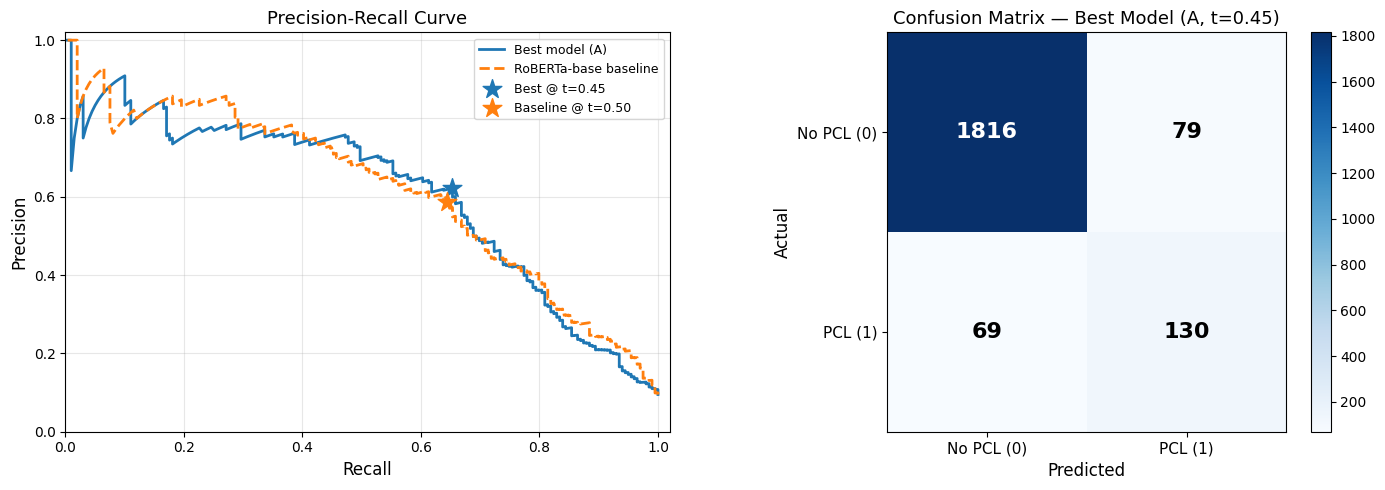

Figure saved to /vol/bitbucket/akc123/PCL_Detection/custom_metrics.png


In [31]:
# ---- Precision-Recall Curve: Best Model vs Baseline ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Precision-Recall Curves ---
ax = axes[0]

# Best model PR curve
prec_best, rec_best, thresholds_best = precision_recall_curve(
    best_metrics['labels'], best_metrics['probs'], pos_label=1)
ax.plot(rec_best, prec_best, label=f'Best model ({best_key})', color='tab:blue', linewidth=2)

# Baseline PR curve
prec_base, rec_base, thresholds_base = precision_recall_curve(
    baseline_dev_metrics['labels'], baseline_dev_metrics['probs'], pos_label=1)
ax.plot(rec_base, prec_base, label='RoBERTa-base baseline', color='tab:orange', linewidth=2, linestyle='--')

# Mark the operating points
ax.scatter([best_metrics['recall']], [best_metrics['precision']],
           marker='*', s=200, color='tab:blue', zorder=5, label=f'Best @ t={best_threshold:.2f}')
ax.scatter([baseline_dev_metrics['recall']], [baseline_dev_metrics['precision']],
           marker='*', s=200, color='tab:orange', zorder=5, label=f'Baseline @ t={thresh_bl:.2f}')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=13)
ax.legend(fontsize=9)
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])
ax.grid(True, alpha=0.3)

# --- Right: Confusion Matrix Heatmap (Best Model) ---
ax = axes[1]

cm = confusion_matrix(best_metrics['labels'], best_metrics['preds'], labels=[0, 1])
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

classes = ['No PCL (0)', 'PCL (1)']
tick_marks = [0, 1]
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, fontsize=11)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes, fontsize=11)

# Annotate each cell with count
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', fontsize=16, fontweight='bold', color=color)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix — Best Model ({best_key}, t={best_threshold:.2f})', fontsize=13)

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/custom_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved to {BASE_DIR}/custom_metrics.png')

## 13. Ablation Study Summary

In [32]:
# ---- Ablation Study Summary ----
ablation_table = pd.DataFrame([
    {'Config': 'Baseline (unweighted CE, t=0.5)', 'Weighted CE': 'No', 'Multi-task': 'No', 'Thresh Opt': 'No',
     'Dev F1': f'{thresh_metrics_bl["f1"]:.4f}'},
    {'Config': 'Config A (full)', 'Weighted CE': 'Yes', 'Multi-task': 'Yes', 'Thresh Opt': 'Yes',
     'Dev F1': f'{thresh_metrics_a["f1"]:.4f}'},
    {'Config': 'Config B (full)', 'Weighted CE': 'Yes', 'Multi-task': 'Yes', 'Thresh Opt': 'Yes',
     'Dev F1': f'{thresh_metrics_b["f1"]:.4f}'},
    {'Config': 'A w/o Multi-task', 'Weighted CE': 'Yes', 'Multi-task': 'No', 'Thresh Opt': 'Yes',
     'Dev F1': f'{thresh_metrics_abl_nomt["f1"]:.4f}'},
    {'Config': 'A w/o Threshold Opt', 'Weighted CE': 'Yes', 'Multi-task': 'Yes', 'Thresh Opt': 'No',
     'Dev F1': f'{thresh_metrics_abl_nothresh["f1"]:.4f}'},
    {'Config': 'A w/o Weighted CE', 'Weighted CE': 'No', 'Multi-task': 'Yes', 'Thresh Opt': 'Yes',
     'Dev F1': f'{thresh_metrics_abl_nowe["f1"]:.4f}'},
])

print('='*80)
print('ABLATION STUDY')
print('='*80)
print(ablation_table.to_string(index=False))

# Component contributions
full_f1 = thresh_metrics_a['f1']
print(f'\nComponent contributions (F1 drop when removed from Config A):')
print(f'  Multi-task learning:    {full_f1 - thresh_metrics_abl_nomt["f1"]:+.4f}')
print(f'  Threshold optimisation: {full_f1 - thresh_metrics_abl_nothresh["f1"]:+.4f}')
print(f'  Weighted CE:            {full_f1 - thresh_metrics_abl_nowe["f1"]:+.4f}')
print(f'\nTotal improvement over baseline: {full_f1 - thresh_metrics_bl["f1"]:+.4f} F1')

ABLATION STUDY
                         Config Weighted CE Multi-task Thresh Opt Dev F1
Baseline (unweighted CE, t=0.5)          No         No         No 0.6139
                Config A (full)         Yes        Yes        Yes 0.6373
                Config B (full)         Yes        Yes        Yes 0.6133
               A w/o Multi-task         Yes         No        Yes 0.6005
            A w/o Threshold Opt         Yes        Yes         No 0.6061
              A w/o Weighted CE          No        Yes        Yes 0.6210

Component contributions (F1 drop when removed from Config A):
  Multi-task learning:    +0.0368
  Threshold optimisation: +0.0312
  Weighted CE:            +0.0162

Total improvement over baseline: +0.0233 F1
